In [ ]:
import os
import sys
import logging
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation
import skyfield as sf
from skyfield.api import load, wgs84, EarthSatellite, N, W,S,E, Star, Angle
import datetime as dt
import time
from skyfield import almanac
from skyfield.framelib import galactic_frame
from skyfield.data import hipparcos
import lumos.calculator
import random
from src.satellites.starlink_sat import *
from src.utils.calculations import *
from src.utils.plots import *
from src.utils.utils import StreamToLogger, find_closest_TLE
import lumos.plot
import lumos.brdf.library
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib import colors as mcolors
from astropy.visualization import quantity_support, time_support
quantity_support()  

now = datetime.now()
cwd = os.getcwd()
print(cwd)
cwd = os.path.join(cwd, "../..")
pathToTargets = os.path.join(cwd, "in_LSST_footprint_coordinates.fits")
pathToTLE = os.path.join(cwd, "Skyfield/tle_data")
pathToFiles = os.path.join(cwd, "Skyfield/files")
pathToLogs = os.path.join(cwd, "Skyfield/logs")
pathToPlots = os.path.join(cwd, "Skyfield/plots")
# Create output directory if it doesn't exist
os.makedirs(pathToFiles, exist_ok=True)
os.makedirs(pathToLogs, exist_ok=True)
os.makedirs(pathToPlots, exist_ok=True)

ts = load.timescale()
year = 2025
day_month_i = [1, 1]
day_month_f = [30, 1]
zone_stl = timezone('Etc/GMT-6')
zone = timezone('Chile/Continental')
utc = timezone('UTC')
obs_start = dt.datetime(year,day_month_i[1], day_month_i[0],0,0,0,0)
obs_end = dt.datetime(year,day_month_f[1], day_month_f[0],0,0,0,0)
local_start = ts.from_datetime(zone.localize(obs_start).astimezone(utc))
local_end = ts.from_datetime(zone.localize(obs_end).astimezone(utc))
# Nsats = 50 # number of starlinks to check
treshold = 15 # tresold for contamination
deltatime = dt.timedelta(seconds=1)

#starlinks = load.tle_file('https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle')
eph = load('de421.bsp')
earth = eph['earth']
sun = eph['sun']
rubin_obs = wgs84.latlon(-30.244633,  -70.749417)
rubinobs_astr = earth +  wgs84.latlon(30.244633*S,  70.749417*W, elevation_m = 2647)



In [ ]:
start_time = datetime.now()


# if Nsats != len(starlinks):
#     random.shuffle(starlinks)
status_names = ['Rise','Culminate', 'Set']
d = 0
eclipse = 0

total_trail = []
total_valid = []
total_event = []
total_invalid = []
total_contamination = []
total_peak_mag = []
total_separation = []
total_closest_approach = []
total_average_mag = []
total_sun_alt_at_ti = []
total_sat_heights = []
total_trail_ti = []
total_sat_alt_at_ti = []
total_peak_intensity = []
total_average_intensity = []
t00 = local_start

while t00 < local_end:
    d = d + 1
    
    tle, starlinks = find_closest_TLE(t00, pathToTLE, zone)
    Nsats = len(starlinks)
    set_plot_style()
    plt.figure(figsize=(10, 5))

    ax = plt.subplot(111, projection='aitoff')
    plt.grid(True)

    tar_plot= True
    sat_ra= []
    sat_dec= []
    sat_dist = []
    sat_t = []
    sat_al = []
    sat_az = []
    travel_dist= []
    sat_hght = []
    sun_al = []
    sun_az = []
    sun_hght = []
    daily_separation = []
    filtered_targets = []
    trailcan_counter = 0
    valid_starlink_counter = 0
    event_counter = 0
    invalid_starlink_counter = 0
    contamination_counter = 0
    skips = 0
    t0 = t00
    t1 = t0 + dt.timedelta(days=1)

    ####L.append(f'\n Observation period: {t0.astimezone(zone).strftime("%Y-%m-%d %H:%M")} to {t1.astimezone(zone).strftime("%Y-%m-%d %H:%M")} \n Time zone: {zone}')
    print(f'Observation period: {t0.astimezone(zone).strftime("%Y-%m-%d %H:%M")} to {t1.astimezone(zone).strftime("%Y-%m-%d %H:%M")} \n Time zone: {zone}')

    f = sf.almanac.dark_twilight_day(eph, rubin_obs)
    times, events = almanac.find_discrete(t0, t1, f)
    previous_e = f(t0).item()

    for t, e in zip(times, events):
        tstr = str(t.astimezone(zone))[:16]
        if previous_e < e:
            print(f'{tstr} {almanac.TWILIGHTS[e]} starts')
            if str(almanac.TWILIGHTS[e]) == 'Day':
                day_start = t
        else:
            print(f'{tstr} {almanac.TWILIGHTS[previous_e]} ends')
            if (almanac.TWILIGHTS[previous_e]) == 'Day':
                day_end = t
        previous_e = e


    print(f'\n Day starts at:  {day_start.astimezone(zone)}')
    print(f'\n Day ends at: {day_end.astimezone(zone)}')
    sat_num = 0
    for starlink in starlinks[:Nsats+1:1000]:
        
        sat_num = sat_num + 1
        
        #try: 
        ev = 0
        rising_time = []
        setting_time = []
        peak_time = []
        
        time_start, event_start = starlink.find_events(rubin_obs, t0, day_start, altitude_degrees=30.0)
        for t, e in zip(time_start, event_start):
            if e == 0:
                rising_time.append(t)
                event_counter = event_counter + 1
            if e == 1:
                peak_time.append(t)
            if e == 2:
                setting_time.append(t)   

        time_end, event_end = starlink.find_events(rubin_obs, day_end, t1, altitude_degrees=30.0)
        for t, e in zip(time_end, event_end):
            if e == 0:
                rising_time.append(t)
                event_counter = event_counter + 1
            if e == 1:
                peak_time.append(t)
            if e == 2:
                setting_time.append(t)

        print(f'\n Starlink satellite number: {sat_num}, Name: {starlink.name}, # Events: {event_counter}')
        #print('Check point 1 : ',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
        for rise_t, peak_t, set_t in zip(rising_time,peak_time, setting_time):
            # sunlit = starlink.at(rise_t).is_sunlit(eph) | starlink.at(set_t).is_sunlit(eph) | starlink.at(peak_t).is_sunlit(eph)
            # # night = ((rise_t < day_start) | (rise_t > day_end)) & ((set_t < day_start) | (set_t > day_end)) 
            # print(f'Sunlit? {sunlit}')

            ti = rise_t
            skip = 0
            s = len(sat_ra)
            topocentric_old = 0
            while starlink.at(ti).is_sunlit(eph) & (ti < set_t) & (skip < 10):
                
                if ti == rise_t:
                    trailcan_counter = trailcan_counter + 1
                    #L.append(f'\nTrail candidate event! Transit no: {trailcan_counter}, Starlink no: {sat_num}')
                    print(f'Trail candidate event! Transit no: {trailcan_counter}, Starlink no: {sat_num}')
                    print(f'Rising time: {rise_t.astimezone(zone)}, setting time: {set_t.astimezone(zone)}')

                separation = []
                topocentric = trail_event(starlink, rubin_obs, ti, sat_t, sat_al, sat_az, sat_hght)   

                if topocentric is None:
                    
                    print(f'Step at ti in event {trailcan_counter} for satellite {starlink.name} is taking too long, stopping. / higher than altitude limit of <2000m')
                    skip = skip + 1
                    ti = ti + deltatime
                    
                    continue
                if topocentric_old != 0:
                    travel_dist.append(topocentric.separation_from(topocentric_old).arcseconds())
                topocentric_old = topocentric
                ti = ti + deltatime
    sat_time = [t.to_astropy() for t in sat_t]
    sat_coord = SkyCoord(az=sat_az, alt=sat_al, frame='altaz', unit='deg', obstime=sat_time, location=EarthLocation.of_site('rubin'))
    scatter = ax.scatter(-sat_coord.az.wrap_at(180 * u.degree).radian, sat_coord.alt.radian, marker='o', c = sat_hght, cmap = 'plasma')
    plt.title(f'Starlink positions for {t00.astimezone(zone)} to {obs_end.astimezone(zone)}', y=1.08)
    ax.set_xlabel('Azimuth (degrees)')
    #fig.colorbar(scatter).set_label("Distance [km]")

    # Dec is already in degrees, so just label it
    ax.set_ylabel('Altitude (degrees)')    
    # ax.set_ylim(np.radians(30), np.radians(90))  # Set y-axis limits to show only altitudes above 30 degrees
    plt.tight_layout()
    plt.show()

    end_time = datetime.now()
    total_seconds = (end_time - start_time).total_seconds()
    # Convert seconds to hours, minutes, and seconds
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = total_seconds % 60
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time()))
    # Print the formatted runtime
    print(f"Current time: {current_time} Runtime: {hours}h {minutes}m {seconds:.2f}s , Day {d} completed.")

    #print('Check point 5 : ',time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
    t00 = t1 + dt.timedelta(days=4)


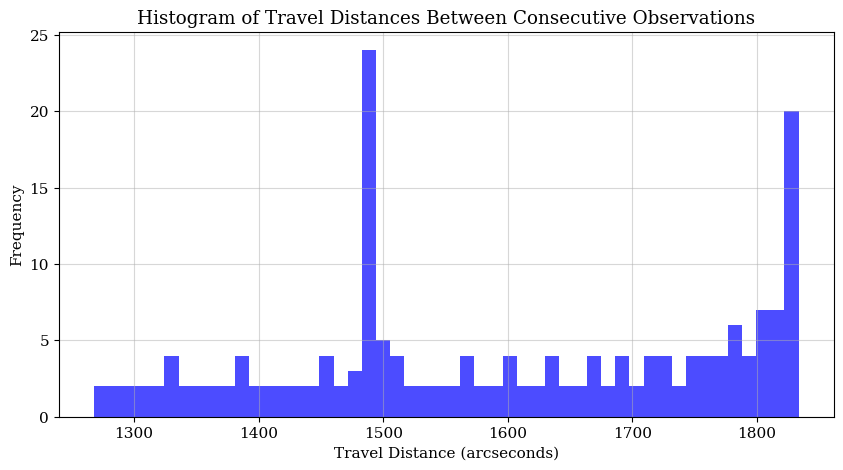

min travel distance: 1268.008372178471, max travel distance: 1833.248138602894, average travel distance: 1599.2286048229655


In [10]:
#make histogram of travel_dist
plt.figure(figsize=(10, 5))
plt.hist(travel_dist, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Travel Distances Between Consecutive Observations')
plt.xlabel('Travel Distance (arcseconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print(f'min travel distance: {min(travel_dist)}, max travel distance: {max(travel_dist)}, average travel distance: {np.mean(travel_dist)}')